In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
if '..' not in sys.path: sys.path.append('..')

from fqc import uccsd, util, models
import numpy as np
import h5py

import config
data_path = config.DATA_PATH

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import warnings; warnings.simplefilter('ignore')

data_path = '/project/ftchong/qoc/chris/'

## Circuit + Slice Setup
Here, we compute the UCCSD circuit associated with LiH, and then select a slice to experiment with later

In [2]:
theta_vector = [np.random.rand() * 2 * np.pi for _ in range(8)]
print(theta_vector)

[5.971532681527901, 3.310494643904958, 1.7402080481651863, 2.6731618090992724, 1.7315910576535296, 3.506417113530682, 5.938869870851662, 4.490350686442051]


In [3]:
circuit = uccsd.get_uccsd_circuit('LiH', theta_vector)
coupling_list = util.circuitutil.get_nearest_neighbor_coupling_list(2, 2)
optimized_circuit = util.optimize_circuit(circuit, coupling_list)
optimized_circuit.draw(output='text', line_length=4000)

In [4]:
slices = uccsd.get_uccsd_slices(optimized_circuit, granularity=2, dependence_grouping=True)
my_slice = slices[5] # Try 5
my_slice.circuit.draw(output='text', line_length=4000)

## Optimization infrastructure
(This is messy right now, I'm in the process of cleaning, and I'll be moving some stuff into standalone scripts)

In [5]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.extensions.standard import RZGate

In [6]:
def get_U_from_angle(theta):
    my_slice.update_angles([theta * np.pi / 180.0] * len(my_slice._parameterized_gates))
    return util.get_unitary(my_slice.circuit)


base_angle = 90
angle_range = np.linspace(10, 170, (170 - 10) / 5 + 1)

unitaries = {}
for i, angle in enumerate(angle_range):
    unitaries[angle] = get_U_from_angle(angle)
    
    sys.stdout.write("\rGenerated Unitaries: " + str(i) + "/" + str(len(angle_range) -1 ))
    sys.stdout.flush()

Generated Unitaries: 32/32

In [7]:
from quantum_optimal_control.helper_functions.grape_functions import transmon_gate
from quantum_optimal_control.main_grape.grape import Grape
from quantum_optimal_control.core import hamiltonian

import os, sys, math
from datetime import datetime
import config

In [8]:
data_path = config.DATA_PATH
file_name = datetime.today().strftime('%h%d')

d = 2
N = 4 # Number of qubits for the circuit
connected_qubit_pairs = util.circuitutil.get_nearest_neighbor_coupling_list(2, 2, directed=False)

H0 = hamiltonian.get_H0(N, d)
Hops, Hnames = hamiltonian.get_Hops_and_Hnames(N, d, connected_qubit_pairs)
states_concerned_list = hamiltonian.get_full_states_concerned_list(N, d)
maxA = hamiltonian.get_maxA(N, d, connected_qubit_pairs)

In [9]:
import contextlib, io

class StdoutFilter(io.TextIOBase):
    def __init__(self, fun_filter, fun_map, old_stdout):
        self.fun_filter = fun_filter
        self.fun_map = fun_map
        n_map = fun_map
        self.old_stdout = old_stdout
        self.line = ""
    
    def write(self, s):
        self.line += s
        lines = self.line.split("\n")
        for line in lines[:-1]:
            if self.fun_filter(line):
                self.old_stdout.write(self.fun_map(line + "\n"))
        self.line = lines[-1]
        self.old_stdout.flush()

@contextlib.contextmanager
def filter_stdout(fun_filter=lambda x: True, fun_map=lambda x: x):
    old_stdout = sys.stdout
    sys.stdout = StdoutFilter(fun_filter, fun_map, old_stdout)
    try:
        yield
    finally:
        sys.stdout = old_stdout

@contextlib.contextmanager
def filter_GRAPE(one_line=True, prefix_data={}, include_saveloc=True, include_graphbuilding=True):
    def filter_line(l):
        if l.startswith('Error'):
            return True
        if l.startswith('data saved'):
            return include_save_loc
        else:
            return include_graphbuilding
    
    def map_line(l):
        if len(prefix_data) == 0:
            return ('\r' + l[:-1]) if one_line else l
        
        with_prefix = str(prefix_data) + ' ' + l
        return ('\r' + with_prefix[:-1]) if one_line else with_prefix
    
    with filter_stdout(filter_line, map_line):
        yield
    
    if one_line:
        print('')

In [10]:
max_iterations = 2000
decay =  max_iterations / 2

# Converge with high accuracy (1e-4) for the reference pulse
convergence = {'rate': 0.02, 'max_iterations': max_iterations,
               'conv_target':1e-3, 'learning_rate_decay':decay, 'min_grad': 1e-12}
reg_coeffs = {}

grape_params = {
    'H0': H0, 'Hops': Hops, 'Hnames': Hnames, 'states_concerned_list': states_concerned_list,
    'reg_coeffs': reg_coeffs,
    'use_gpu': False, 'sparse_H': False,
    'method': 'ADAM', 'maxA': maxA,
    'show_plots': False,
    'file_name': file_name, 'data_path': data_path,
    'save': False
}

U = transmon_gate(unitaries[base_angle], d)

### Optimizing Iterations/Runtime over `total_time`

In [11]:
pulse_lens = np.linspace(5, 65, 60 / 3 + 1)
#pulse_lens = np.linspace(1, 11, 6)
numTrials = 5

pl_data = np.full((len(pulse_lens), numTrials, 2), np.nan)

randvals = [np.random.uniform(5.0, 175.0) for _ in range(numTrials)]
print(randvals)

rand_Us = [transmon_gate(get_U_from_angle(randvals[i]), d) for i in range(numTrials)]


for i, pl in enumerate(pulse_lens):
    for trial in range(numTrials):
        steps = int(pl * 20)
        with filter_GRAPE(prefix_data='[pulse_len={:3.2f},trial={}]'.format(pl, trial)):
            SS = Grape(**grape_params, U=rand_Us[trial], total_time=pl, steps=steps, convergence=convergence)
            pl_data[i, trial, 0], pl_data[i, trial, 1] = SS.iterations, SS.elapsed

np.savez('pulse_len_data.npz', data=pl_data, index=pulse_lens, trials=numTrials)
print('Saved to file')

[23.838220708727913, 68.84107217492235, 116.362302752233, 115.04304219647915, 174.81635458064878]
[pulse_len=5.00,trial=0] Error = :2.14e-01; Runtime: 27.7s; Iterations = 2000, grads =   2.879e-07, unitary_metric = 0.99998
[pulse_len=5.00,trial=1] Error = :1.97e-01; Runtime: 27.7s; Iterations = 2000, grads =   2.127e-07, unitary_metric = 0.99998
[pulse_len=5.00,trial=2] Error = :2.53e-01; Runtime: 27.8s; Iterations = 2000, grads =   2.335e-07, unitary_metric = 0.99998
[pulse_len=5.00,trial=3] Error = :2.32e-01; Runtime: 27.9s; Iterations = 2000, grads =   6.174e-07, unitary_metric = 0.99998
[pulse_len=5.00,trial=4] Error = :4.13e-02; Runtime: 27.8s; Iterations = 2000, grads =   3.541e-07, unitary_metric = 0.99999
[pulse_len=8.00,trial=0] Error = :1.56e-01; Runtime: 40.5s; Iterations = 2000, grads =   4.216e-07, unitary_metric = 0.99998
[pulse_len=8.00,trial=1] Error = :1.13e-01; Runtime: 39.7s; Iterations = 2000, grads =   2.559e-06, unitary_metric = 0.99997
[pulse_len=8.00,trial=2] Er

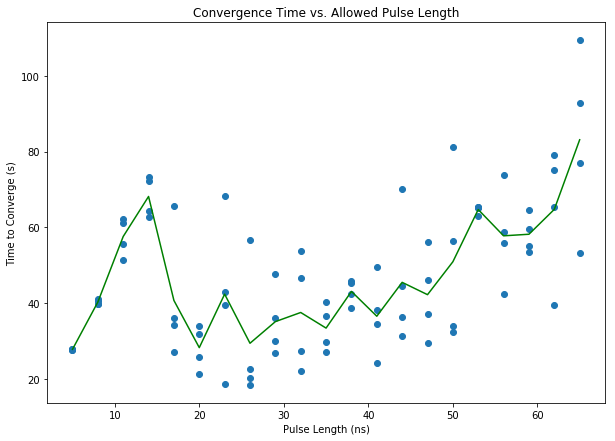

In [50]:
with np.load('pulse_len_data.npz') as f:
    d = f['data'][:,0:4,:]
    ind = f['index']

plt.rcParams['axes.facecolor'] = 'white'
scatterData = np.concatenate(np.dstack((np.broadcast_to(ind[:, np.newaxis], d[:, :, 0].shape), d[:, :, 0])), axis=0)
plt.figure(figsize=(10, 7))
plt.scatter(scatterData[:, 0], scatterData[:, 1])
plt.plot(ind, d[: ,: ,0].mean(axis=1), color='g')
plt.title('It vs. Allowed Pulse Length')
plt.xlabel('Pulse Length (ns)')
plt.ylabel('Time to Converge (s)')
plt.show()

Based on the above, we will target pulse range of length around 25ns

In [12]:
total_time = 40.0
steps = int(total_time * 20)

angles = np.linspace(20, 160, (160 - 20) / 10 + 1)
freqsRemoved = range(0, 401, 25)
numTrials = 3

#angles = np.linspace(40, 50, 10 / 5 + 1)
#freqsRemoved = range(0, 401, 25)
#numTrials = 2

fft_compressed_data = np.full((len(angles), numTrials, len(freqsRemoved), 2), np.nan)

for i, angle in enumerate(angles):
    for trial in range(numTrials):
        # Find a pulse using a random initial guess that works
        with filter_GRAPE(prefix_data='[angle={:.3f},trial={}]'.format(angle, trial)):
            pulse = Grape(**grape_params, U=transmon_gate(unitaries[angle], d),
                          total_time=total_time, steps=steps, convergence=dict(convergence, rate=0.02))
        
        # Take the RFFT
        pulse_rfft = np.fft.rfft(pulse.uks, axis=1)
        indices = abs(pulse_rfft).argsort(axis=1)
        
        for j, removedFreqs in enumerate(freqsRemoved):
            pulse_rfft[np.arange(pulse.uks.shape[0])[:, np.newaxis], indices[:, :removedFreqs]] = 0
            
            with filter_GRAPE(prefix_data='\t[removed={}]'.format(removedFreqs)):
                maxAs = np.array(maxA)[:, np.newaxis]
                to_pulse = Grape(**grape_params, U=transmon_gate(unitaries[angle], d),
                                total_time=total_time, steps=steps, convergence=dict(convergence, rate=0.01),
                                initial_guess=np.clip(np.fft.irfft(pulse_rfft, pulse.uks.shape[1], axis=1), -1 * maxAs, maxAs))
            
            fft_compressed_data[i, trial, j, 0] = to_pulse.iterations
            fft_compressed_data[i, trial, j, 1] = to_pulse.elapsed

np.savez(data_path + 'fft_compression_data2.npz', data=fft_compressed_data, index_angles=angles, index_freqs=freqsRemoved, trials=numTrials)
print('Saved to file')

[angle=20.000,trial=0] Error = :9.41e-04; Runtime: 34.6s; Iterations = 430, grads =   6.864e-03, unitary_metric = 1.00011
	[removed=0] Error = :9.40e-04; Runtime: 0.8s; Iterations = 0, grads =   6.864e-03, unitary_metric = 1.00011
	[removed=25] Error = :9.29e-04; Runtime: 0.8s; Iterations = 0, grads =   6.460e-03, unitary_metric = 1.00011
	[removed=50] Error = :9.98e-04; Runtime: 0.8s; Iterations = 0, grads =   7.998e-03, unitary_metric = 1.00011
	[removed=75] Error = :9.47e-04; Runtime: 7.7s; Iterations = 74, grads =   2.136e-03, unitary_metric = 1.00014
	[removed=100] Error = :9.61e-04; Runtime: 8.3s; Iterations = 77, grads =   2.612e-03, unitary_metric = 1.00010
	[removed=125] Error = :9.88e-04; Runtime: 7.6s; Iterations = 73, grads =   3.148e-03, unitary_metric = 1.00012
	[removed=150] Error = :8.97e-04; Runtime: 7.5s; Iterations = 69, grads =   2.998e-03, unitary_metric = 1.00012
	[removed=175] Error = :9.68e-04; Runtime: 7.2s; Iterations = 64, grads =   3.858e-03, unitary_metric 

(15, 17)


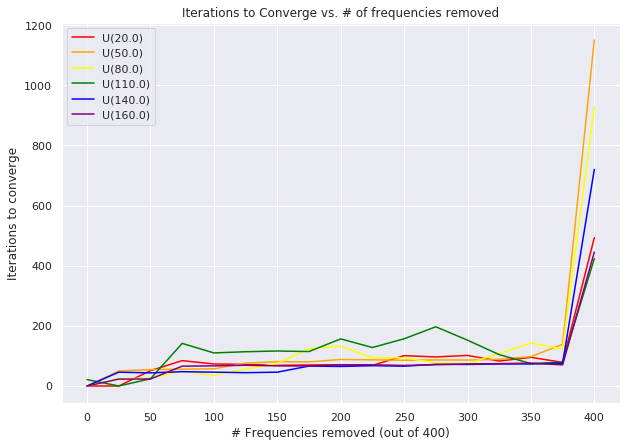

In [30]:
sns.set()
with np.load(data_path + 'fft_compression_data.npz') as f:
    d = f['data']
    ind_angles = f['index_angles']
    ind_freqs = f['index_freqs']
    trials = f['trials']

iter_data = d[:, :, :, 0].mean(axis=1)
plt.figure(figsize=(10, 7))
print(iter_data.shape)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
ais = [0, 3, 6, 9, 12, 14]

for i in range(len(ais)):
    plt.plot(ind_freqs, iter_data[ais[i]], color=colors[i], label='U({:.1f})'.format(ind_angles[ais[i]]))
    
plt.title('Iterations to Converge vs. # of frequencies removed')
plt.xlabel('# Frequencies removed (out of 400)')
plt.ylabel('Iterations to converge')
plt.legend()
plt.show()